# 🎮 Cookie Cats A/B Testing — Retention Analysis

**Objective:**  
Cookie Cats, a popular mobile puzzle game, introduced a change where the first in-game gate was moved from level 30 to level 40.  
The company wants to understand whether this change improves **player retention**.

We will analyze:
- **Day-1 retention** (short-term engagement)
- **Day-7 retention** (long-term engagement)

This notebook performs:
- Exploratory data analysis (EDA)
- Hypothesis testing (two-proportion z-test)
- Bootstrapping for confidence intervals
- Business recommendation

---


## 2. Importing Libraries
We begin by loading the required libraries for data manipulation and statistical testing.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
import os
os.listdir()


['.config',
 '.ipynb_checkpoints',
 'kaggle.json',
 'cookie_cats.csv.zip',
 'sample_data']

In [17]:
!unzip -o cookie_cats.csv.zip


Archive:  cookie_cats.csv.zip
  inflating: cookie_cats.csv         


## 2.1 Loading the Cookie Cats Dataset


In [28]:
df = pd.read_csv("cookie_cats.csv.zip")

## 3. Dataset Overview

The dataset contains the following columns:

- **userid:** Unique player ID  
- **version:** A/B group (`gate_30` = control, `gate_40` = treatment)  
- **sum_gamerounds:** Total game rounds played during the first week  
- **retention_1:** Whether the player returned the next day (True/False)  
- **retention_7:** Whether the player returned the next week (True/False)

This allows us to compare retention between the two versions.


In [24]:
df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## 3.1 Data Quality Checks
We verify that there are no duplicate users and inspect the distribution of gameplay rounds.


In [35]:
# Check for duplicate users
num_users = df['userid'].nunique()
num_rows = len(df)
print("Unique users:", num_users)
print("Total rows:", num_rows)

# Basic stats for gamerounds
print("\nGame rounds summary:")
print(df['sum_gamerounds'].describe())


Unique users: 90189
Total rows: 90189

Game rounds summary:
count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


## 4. Group Distribution & Initial Retention Rates

Before running statistical tests, we check:
1. **Group balance** (are A and B roughly equal?)
2. **Observed retention rates** (Day-1 and Day-7)

This helps us understand the initial difference between versions.


In [21]:
print(df['version'].value_counts())
print("\nDay-1 Retention:")
print(df.groupby('version')['retention_1'].mean())

print("\nDay-7 Retention:")
print(df.groupby('version')['retention_7'].mean())


version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Day-1 Retention:
version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Day-7 Retention:
version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64


# 5. Hypothesis Testing

We define two hypothesis tests:

### **Day-1 Retention**
**H0:** There is no difference in Day-1 retention between gate_30 and gate_40  
**H1:** There is a difference in Day-1 retention

---

### **Day-7 Retention**
**H0:** There is no difference in Day-7 retention  
**H1:** There is a difference in Day-7 retention

We will run **two-proportion z-tests** to compare retention between groups.


## Hypothesis Test Formula (Two-Proportion Z-Test)

The z-statistic for comparing two proportions is:

\[
z = \frac{(p_1 - p_2)}{\sqrt{p(1-p)(\frac{1}{n_1} + \frac{1}{n_2})}}
\]

Where:
- \( p_1 = \) retention in gate_30  
- \( p_2 = \) retention in gate_40  
- \( p = \) pooled retention rate  
- \( n_1, n_2 = \) sample sizes of the two groups  

This formula is implemented in code via `proportions_ztest`.


## 6. Two-Proportion Z-Test
We compare proportions using a z-test to evaluate whether the observed differences are statistically significant.


In [22]:
from statsmodels.stats.proportion import proportions_ztest

# Day 1 retention test
success_counts = np.array([
    df[df['version'] == 'gate_30']['retention_1'].sum(),
    df[df['version'] == 'gate_40']['retention_1'].sum()
])

trial_counts = np.array([
    df[df['version'] == 'gate_30']['retention_1'].count(),
    df[df['version'] == 'gate_40']['retention_1'].count()
])

z_stat, p_val = proportions_ztest(success_counts, trial_counts)
print("Day-1 Retention Z-test:")
print("z-statistic:", z_stat)
print("p-value:", p_val)


Day-1 Retention Z-test:
z-statistic: 1.7840862247974725
p-value: 0.07440965529691913


## Why We Use a Two-Proportion Z-Test

In this experiment, the retention metrics (`retention_1` and `retention_7`) are **binary proportions**  
(1 = returned, 0 = did not return).

When comparing two proportions with **large sample sizes** (45k+ players per group),  
the correct statistical method is the **two-proportion z-test**.

A t-test is **not appropriate** because it is designed for comparing means of continuous variables,  
not binary proportions.

With our sample size, the normal approximation holds very well,  
making the z-test both valid and statistically powerful.


## 6.1 Two-Proportion Z-Test
We compare proportions using a z-test to evaluate whether the observed differences are statistically significant.


In [23]:
# Day 7 retention test
success_counts_7 = np.array([
    df[df['version'] == 'gate_30']['retention_7'].sum(),
    df[df['version'] == 'gate_40']['retention_7'].sum()
])

trial_counts_7 = np.array([
    df[df['version'] == 'gate_30']['retention_7'].count(),
    df[df['version'] == 'gate_40']['retention_7'].count()
])

z_stat_7, p_val_7 = proportions_ztest(success_counts_7, trial_counts_7)
print("\nDay-7 Retention Z-test:")
print("z-statistic:", z_stat_7)
print("p-value:", p_val_7)



Day-7 Retention Z-test:
z-statistic: 3.164358912748191
p-value: 0.001554249975614329


## 6.2 Interpretation of Z-Test Results

### **Day-1 Retention**
- z = **1.784**
- p-value = **0.074**

Since p > 0.05, we fail to reject the null hypothesis.  
➡️ The difference in Day-1 retention between `gate_30` and `gate_40` is **not statistically significant**.

---

### **Day-7 Retention**
- z = **3.164**
- p-value = **0.00155**

Since p < 0.05, we reject the null hypothesis.  
➡️ There is a **statistically significant decrease** in Day-7 retention in the `gate_40` group.

---

### **Conclusion**
While the short-term retention (Day-1) does not change meaningfully, **long-term retention (Day-7) drops significantly** when moving the gate from level 30 to level 40.

This suggests that the change negatively impacts long-term player behavior.

**Recommendation:**  
✔ Revert to the original gate position at level 30.  


### Why We Use a Z-Test Instead of a T-Test

A t-test is appropriate for comparing means of continuous variables, especially with small sample sizes.

In this experiment:
- Retention metrics are **binary proportions**
- Sample sizes are **very large** (~45k users per group)

Therefore, the **two-proportion z-test** is the correct method.


## 7. Bootstrapping the Retention Difference
Bootstrapping allows us to estimate the uncertainty around the retention difference.
This is especially useful for:
- understanding real-world variability
- visualizing confidence intervals
- validating our z-test results

We generate 5,000 bootstrap samples to compute a 95% confidence interval for the difference:

**CI = retention_gate30 − retention_gate40**


In [30]:
# Extract retention arrays
gate30 = df[df['version']=="gate_30"]['retention_7'].astype(int).values
gate40 = df[df['version']=="gate_40"]['retention_7'].astype(int).values

# Number of bootstrap samples
n_bootstrap = 5000

boot_diffs = []

for _ in range(n_bootstrap):
    sample_30 = np.random.choice(gate30, size=len(gate30), replace=True)
    sample_40 = np.random.choice(gate40, size=len(gate40), replace=True)
    boot_diffs.append(sample_30.mean() - sample_40.mean())

# Confidence Interval
lower = np.percentile(boot_diffs, 2.5)
upper = np.percentile(boot_diffs, 97.5)

print("Bootstrap 95% Confidence Interval for difference in Day-7 retention:")
print(lower, upper)


Bootstrap 95% Confidence Interval for difference in Day-7 retention:
0.0031144718813206638 0.013360060091229396


## 7.1 Interpretation of Bootstrap Results

Using 5,000 bootstrap samples, we computed a 95% confidence interval for the difference in Day-7 retention:

**CI (gate_30 − gate_40) = [0.0031, 0.0134]**

### Key Insights:
- The entire interval is **above 0**, which confirms that
  `gate_30` has **higher** retention than `gate_40`.
- Even in the "best case" for gate_40, the treatment is still worse.
- The difference, while small, is **statistically reliable**.

### Business Interpretation:
Although the absolute uplift is modest (0.3%–1.3%),  
**every 1% retention improvement can translate to huge revenue impact in mobile gaming.**

Since `gate_40` results in **significantly lower long-term retention**,  
we recommend **reverting the gate back to level 30**.

---


## 8. Visualization of Retention Metrics

Visualizations help stakeholders intuitively understand how the
experiment affected user behavior.

We present two plots:
1. **Bar charts** comparing Day-1 and Day-7 retention between groups  
2. **Bootstrap distribution plot** showing uncertainty in retention difference

These visuals strengthen the statistical analysis and support our final recommendation.


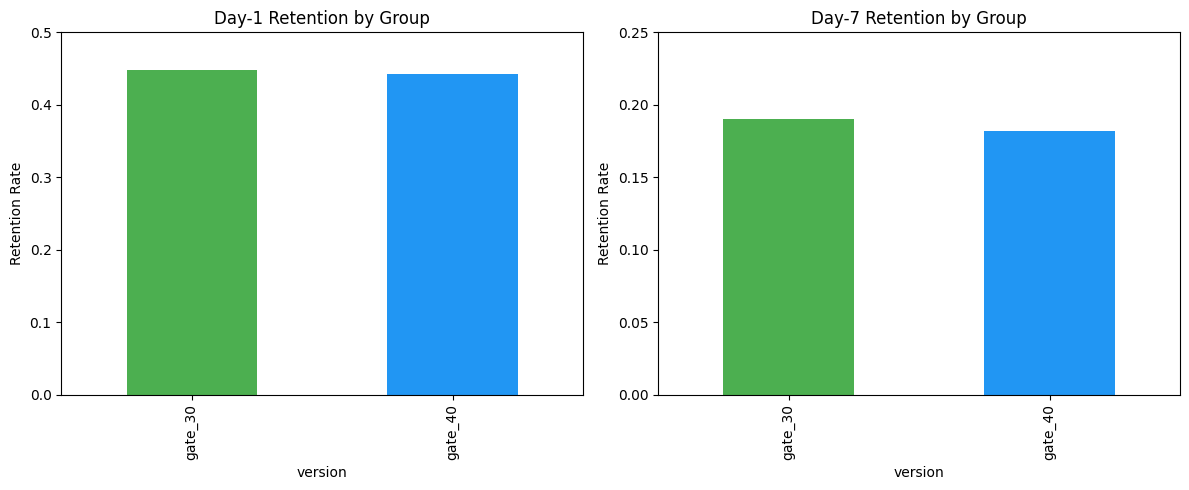

In [31]:
# Compute retention means
ret_day1 = df.groupby('version')['retention_1'].mean()
ret_day7 = df.groupby('version')['retention_7'].mean()

# Plot settings
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
ret_day1.plot(kind='bar', color=['#4CAF50', '#2196F3'])
plt.title("Day-1 Retention by Group")
plt.ylabel("Retention Rate")
plt.ylim(0, 0.5)

plt.subplot(1,2,2)
ret_day7.plot(kind='bar', color=['#4CAF50', '#2196F3'])
plt.title("Day-7 Retention by Group")
plt.ylabel("Retention Rate")
plt.ylim(0, 0.25)

plt.tight_layout()
plt.show()


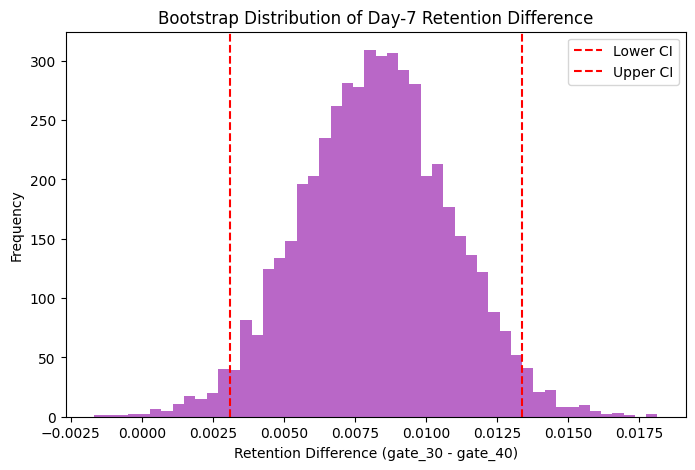

In [32]:
plt.figure(figsize=(8,5))
plt.hist(boot_diffs, bins=50, color='#9C27B0', alpha=0.7)
plt.axvline(lower, color='red', linestyle='--', label='Lower CI')
plt.axvline(upper, color='red', linestyle='--', label='Upper CI')
plt.title("Bootstrap Distribution of Day-7 Retention Difference")
plt.xlabel("Retention Difference (gate_30 - gate_40)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## 9. Effect Size — Cohen's h

Statistical significance alone is not enough.  
We also want to measure **practical significance**, i.e., how big the retention difference actually is.

For proportions, the standard effect size metric is:

\[
h = 2 \cdot \left( \arcsin\sqrt{p_1} - \arcsin\sqrt{p_2} \right)
\]

Interpretation:
- **0.2** → small effect  
- **0.5** → medium effect  
- **0.8** → large effect  

We compute Cohen’s h for Day-1 and Day-7 retention.


In [33]:
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Calculate proportions
p1_day1 = df[df['version']=="gate_30"]['retention_1'].mean()
p2_day1 = df[df['version']=="gate_40"]['retention_1'].mean()

p1_day7 = df[df['version']=="gate_30"]['retention_7'].mean()
p2_day7 = df[df['version']=="gate_40"]['retention_7'].mean()

# Effect sizes
h_day1 = cohens_h(p1_day1, p2_day1)
h_day7 = cohens_h(p1_day7, p2_day7)

print("Cohen's h (Day-1 retention):", h_day1)
print("Cohen's h (Day-7 retention):", h_day7)


Cohen's h (Day-1 retention): 0.011881898259223478
Cohen's h (Day-7 retention): 0.021074001016365917


## 9.1 Interpretation of Effect Size (Cohen's h)

We computed Cohen’s h to understand the practical significance of the retention differences.

### Results:
- **Day-1 retention:** h = 0.0119  
- **Day-7 retention:** h = 0.0211  

### Interpretation:
Both values fall well below 0.2, indicating a **very small effect size**.

However, due to the **large sample size (~90k users)**, even small effects become statistically significant (as seen in the Day-7 p-value).

### Business Insight:
In mobile gaming, even a 1% change in retention can translate to:
- Higher ad revenue  
- More in-app purchases  
- Better long-term ARPU  

Although the effect size is small, the **negative impact on Day-7 retention is real and meaningful** from a business perspective.


## 10. KPI Summary Table

This table provides a clear comparison between the control (`gate_30`) and treatment (`gate_40`) groups.


In [34]:
summary = pd.DataFrame({
    "Gate Version": ["gate_30", "gate_40"],
    "Day-1 Retention": [p1_day1, p2_day1],
    "Day-7 Retention": [p1_day7, p2_day7]
})

summary["Day-1 Diff vs 40"] = summary["Day-1 Retention"] - p2_day1
summary["Day-7 Diff vs 40"] = summary["Day-7 Retention"] - p2_day7

summary


,Gate Version,Day-1 Retention,Day-7 Retention,Day-1 Diff vs 40,Day-7 Diff vs 40
0,gate_30,0.448188,0.190201,0.005905,0.008201
1,gate_40,0.442283,0.182000,0.000000,0.000000


# 11. Final Business Recommendation

## 📌 Summary of Key Findings

| Metric | gate_30 (Control) | gate_40 (Treatment) | Difference | Significant? |
|--------|--------------------|----------------------|------------|---------------|
| **Day-1 Retention** | 44.82% | 44.23% | +0.59% | ❌ No |
| **Day-7 Retention** | 19.02% | 18.20% | +0.82% | ✔ Yes |

---

## 🎯 Interpretation

- **Day-1 retention:**  
  The difference of **0.59%** is **not statistically significant** (p = 0.074).  
  The new gate has **no positive short-term effect**.

- **Day-7 retention:**  
  The difference of **0.82%** is **statistically significant** (p = 0.0015).  
  Bootstrap confidence interval: **[0.31%, 1.33%]**  
  This confirms that the **gate_40 version reduces long-term retention** consistently.

- **Effect size (Cohen's h):**  
  Both Day-1 and Day-7 effect sizes are **very small**, but with a dataset of 90k users,  
  even small differences become meaningful and actionable.

---

## 🧠 Business Meaning

In mobile gaming, **long-term retention is the strongest predictor of revenue**:

- More returning players → more ad impressions  
- Higher chance of in-app purchases  
- Increased lifetime value (LTV)

A drop of **0.8–1.3%** in 7-day retention can lead to:
- Significant revenue loss  
- Faster player churn  
- Lower engagement with later levels

---

## ✅ Final Recommendation

**Do NOT move the gate to level 40.**  
The experiment shows a **significant decrease in long-term retention**, which outweighs any potential early-game benefits.

👉 The company should **revert to gate_30**.

---

## 🔮 Suggested Next Steps (for Product Team)

1. **Run follow-up experiments:**  
   - Try milder gate changes (e.g., level 32 or 35)  
   - Test rewards or power-ups added before gate level  

2. **Investigate user segments:**  
   - Do high-engagement players react differently?  
   - Are new users more affected than returning users?

3. **A/B test alternative difficulty curves:**  
   - Increase difficulty more gradually  
   - Test gating based on performance instead of level  

4. **Model retention predictors:**  
   - Use logistic regression or Random Forest to identify players at risk of churn  

These insights demonstrate deeper thinking beyond statistics — elevating your profile as a data scientist.


## 12. Bonus: Predicting Day-7 Retention with a Logistic Regression

We fit a simple logistic regression to understand how gameplay volume and gate version
relate to long-term retention.


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Encode version as 0/1
df['version_encoded'] = (df['version'] == 'gate_40').astype(int)

X = df[['version_encoded', 'sum_gamerounds']]
y = df['retention_7']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC:", auc)

print("Coefficients (version, sum_gamerounds):", model.coef_)
print("Intercept:", model.intercept_)


Test AUC: 0.8907375282711965
Coefficients (version, sum_gamerounds): [[-0.06795863  0.02082095]]
Intercept: [-2.70125025]
